In [5]:
#transformada de hough (sin usar librerías)

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math


In [6]:
#Función para aplicar el filtro de convolución con padding
def convolucion(img, kernel):
    #Obtenemos las dimensiones de la imagen y del kernel
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    #Calculamos el padding
    pad_h = int((kernel_h - 1) / 2)
    pad_w = int((kernel_w - 1) / 2)
    #Creamos una imagen con padding
    img_pad = np.zeros((img_h + (2 * pad_h), img_w + (2 * pad_w)))
    #Copiamos la imagen original en la imagen con padding
    img_pad[pad_h:img_h + pad_h, pad_w:img_w + pad_w] = img
    #Creamos una imagen con las dimensiones de la imagen original
    img_conv = np.zeros(img.shape)
    #Aplicamos el filtro de convolución
    for i in range(img_h):
        for j in range(img_w):
            img_conv[i, j] = np.sum(img_pad[i:i + kernel_h, j:j + kernel_w] * kernel)
    return img_conv

#Se toma el código de arriba para crear la función canny
def canny(img):
    #Se aplica el filtro gaussiano a la imagen para suavizarla
    gauss_kernel = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4],
                            [1, 4, 6, 4, 1]]) / 256

    #Se convierte la imagen a escala de grises
    img_gauss = convolucion(img, gauss_kernel)

    #Se aplica el filtro de Sobel para obtener la magnitud del gradiente
    sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    sobel_kernel_diag = np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])
    sobel_kernel_diag2 = np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]])

    img_sobel_x = convolucion(img_gauss, sobel_kernel_x)
    img_sobel_y = convolucion(img_gauss, sobel_kernel_y)
    img_sobel_diag = convolucion(img_gauss, sobel_kernel_diag)
    img_sobel_diag2 = convolucion(img_gauss, sobel_kernel_diag2)

    img_sobel = np.sqrt(np.power(img_sobel_x, 2) + np.power(img_sobel_y, 2) + np.power(img_sobel_diag, 2) + np.power(img_sobel_diag2, 2))

    #Se aplica el filtro de no máximos para afinar los bordes
    img_nms = np.zeros(img_sobel.shape)
    for i in range(1, img_sobel.shape[0] - 1):

        for j in range(1, img_sobel.shape[1] - 1):
            #Se calcula el ángulo del gradiente
            ang = np.arctan2(img_sobel_y[i, j], img_sobel_x[i, j]) * 180 / np.pi
            #Se comprueba el ángulo del gradiente y se compara con los píxeles vecinos
            if (ang < 22.5 and ang > -22.5) or (ang > 157.5 and ang < -157.5):
                if img_sobel[i, j] > img_sobel[i, j + 1] and img_sobel[i, j] > img_sobel[i, j - 1]:
                    img_nms[i, j] = img_sobel[i, j]
            elif (ang > 22.5 and ang < 67.5) or (ang < -112.5 and ang > -157.5):
                if img_sobel[i, j] > img_sobel[i + 1, j + 1] and img_sobel[i, j] > img_sobel[i - 1, j - 1]:
                    img_nms[i, j] = img_sobel[i, j]
            elif (ang > 67.5 and ang < 112.5) or (ang < -67.5 and ang > -112.5):
                if img_sobel[i, j] > img_sobel[i + 1, j] and img_sobel[i, j] > img_sobel[i - 1, j]:
                    img_nms[i, j] = img_sobel[i, j]
            elif (ang > 112.5 and ang < 157.5) or (ang < -22.5 and ang > -67.5):
                if img_sobel[i, j] > img_sobel[i - 1, j + 1] and img_sobel[i, j] > img_sobel[i + 1, j - 1]:
                    img_nms[i, j] = img_sobel[i, j]
    
    #Se aplica el umbral para eliminar los píxeles que no son bordes
    umbral = 0.15* np.max(img_nms)
    img_umbral = np.zeros(img_nms.shape)
    for i in range(img_nms.shape[0]):
        for j in range(img_nms.shape[1]):
            if img_nms[i, j] > umbral:
                img_umbral[i, j] = 1
    
    #Se aplica el algoritmo de Hysteresis para eliminar los píxeles que no son bordes
    img_hysteresis = np.zeros(img_umbral.shape)
    for i in range(1, img_umbral.shape[0] - 1):
        for j in range(1, img_umbral.shape[1] - 1):
            if img_umbral[i, j] == 1:
                if img_umbral[i - 1, j - 1] == 1 or img_umbral[i - 1, j] == 1 or img_umbral[i - 1, j + 1] == 1 or img_umbral[i, j - 1] == 1 or img_umbral[i, j + 1] == 1 or img_umbral[i + 1, j - 1] == 1 or img_umbral[i + 1, j] == 1 or img_umbral[i + 1, j + 1] == 1:
                    img_hysteresis[i, j] = 1
    # Aplicar umbral para obtener una imagen binaria
    img_binaria = (img_hysteresis > 0).astype(np.uint8)

    return img_binaria



#Transformada de Hough 
def hough_transform(img):
    # Rho and Theta ranges    
    thetas = np.deg2rad(np.arange(0, 360))

    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  # max_dist
    rhos = np.linspace(-diag_len, diag_len, int(diag_len * 2.0))


    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    #print(num_thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges
    #print(y_idxs)
    #print(x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            #print(t_idx)
            # Calculate rho. diag_len is added for a positive index
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos





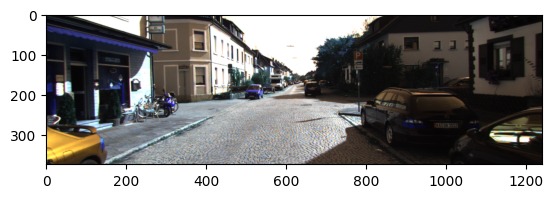

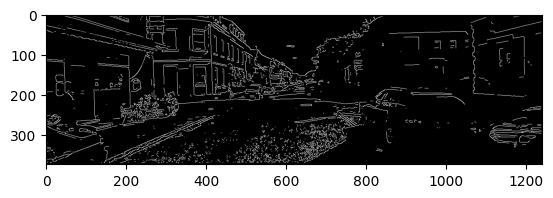

In [7]:
#abrir imagen
img = cv2.imread('images/hough/images/uu_000010.png',1)

#mostrar imagen original
plt.imshow(img, cmap='gray')
plt.show()



img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#aplicar canny
img_canny = canny(img_bw)


#Se muestra la imagen canny
plt.imshow(img_canny, cmap='gray')
plt.show()


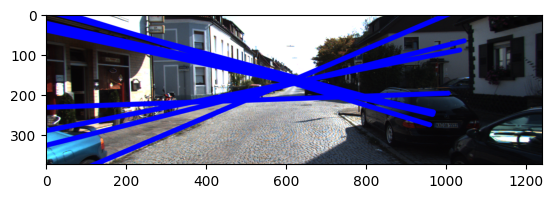

In [8]:

#aplicar hough
accumulator, thetas, rhos = hough_transform(img_canny)

#umbral para la detección de líneas
umbral = 170

#detección de líneas
lines = []
for i in range(accumulator.shape[0]):
    for j in range(accumulator.shape[1]):
        if accumulator[i, j] > umbral:
            lines.append([i, j])

#dibujar líneas
for i in range(len(lines)):
    rho = rhos[lines[i][0]]
    theta = thetas[lines[i][1]]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(img, pt1, pt2, (255,0,0), 10, cv2.LINE_AA)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#mostrar imagen
plt.imshow(img_rgb)
plt.show()
